## Imports

In [1]:
#realizar os "pip install"
%pip install sentencepiece
%pip install pandas
%pip install numpy
%pip install requests
%pip install torch
%pip install transformers
%pip install fairscale

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 1.7 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 835.8 kB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for fairscale: filename=fairscale-0.4.13-py3-none-any.whl size=332105 sha256=47d921a98279d543d75cc894995327c80ae7992e49fac1ecf0ebaf4d35612e42
  Stored in directory: /home/matius/.cache/pip/wheels/5a/88/aa/d84b2cf1bad6b273cbf661640141a82c7b9f496e024f80aac0
Successfully built fairscale


In [1]:
import pandas as pd
import numpy as np
import os
import requests
import torch
from torch import nn
from torch.nn import functional as F
import sentencepiece as spm
import random
from collections import OrderedDict
from matplotlib import pyplot as plt
import time

In [2]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

In [3]:
device

'cuda'

In [67]:
VOCAB_SIZE = 130
BATCH_SIZE = 32
CONTEXT_WINDOW = 16
EPOCHS = 1000
DIM = 128
LOG_INTERVAL = 10
HEADS = 8
LAYERS = 4

In [5]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)

if response.status_code == 200:
    tinyshakespeare = response.text
else:
    print(response.status_code)


In [6]:
tinyshakespeare_list = tinyshakespeare.split("\n")
tinyshakespeare_list = [i for i in tinyshakespeare_list if i != ""]

### Tokenizer - SentencePiece


- paper: https://arxiv.org/pdf/1808.06226
- lib: https://github.com/google/sentencepiece#train-sentencepiece-model
- BPE based tokenizer

In [ ]:
#JUST RUN ONE TIME
spm.SentencePieceTrainer.Train(
    sentence_iterator = iter(tinyshakespeare_list),
    model_prefix = "tinyshakespeare_model",
    vocab_size = VOCAB_SIZE,
    character_coverage = 1.0,
    model_type = "bpe",
    pad_id = 0,
    unk_id = 1,
    bos_id = 2,
    eos_id = 3,
)


In [7]:
sp = spm.SentencePieceProcessor(model_file = "tinyshakespeare_model.model")

In [8]:
#example
sentence = random.choice(tinyshakespeare_list)
print(sentence, "-->", sp.Encode(sentence))

Thy deed, inhuman and unnatural, --> [39, 71, 80, 25, 67, 67, 77, 81, 58, 71, 78, 79, 50, 46, 66, 78, 74, 74, 53, 78, 73, 70, 76, 81]


### Train, test, validation split in batches

In [9]:
dataset_tensor = torch.tensor(sp.Encode(tinyshakespeare))
print(dataset_tensor, dataset_tensor.shape)

tensor([ 66, 114,  64,  ...,  93,  48,  90]) torch.Size([734937])


In [10]:
def get_batch_train(dataset, batch_size, context_window):
    train_data = dataset[:int(.7 * len(dataset))]
    ix = torch.randint(0, train_data.size(0) - context_window - 1, (batch_size,))
    x = torch.stack([train_data[i:i+context_window] for i in ix]).long()
    y = torch.stack([train_data[i+1:i+context_window+1] for i in ix]).long()
    return x, y

x_train, y_train = get_batch_train(dataset_tensor, BATCH_SIZE, CONTEXT_WINDOW)

In [11]:
print(x_train.shape, y_train.shape)

torch.Size([32, 16]) torch.Size([32, 16])


In [12]:
def get_batch_val(dataset, batch_size, context_window):
    val_data = dataset[int(.7 * len(dataset)): int(.85 * len(dataset))]
    ix = torch.randint(0, val_data.size(0) - context_window - 1, (batch_size,))
    x = torch.stack([val_data[i:i+context_window] for i in ix]).long()
    y = torch.stack([val_data[i+1:i+context_window+1] for i in ix]).long()
    return x, y

x_val, y_val = get_batch_val(dataset_tensor, BATCH_SIZE, CONTEXT_WINDOW)

In [13]:
print(x_val.shape, y_val.shape)

torch.Size([32, 16]) torch.Size([32, 16])


In [14]:
def get_batch_test(dataset, batch_size, context_window):
    test_data = dataset[int(.85 * len(dataset)): len(dataset)]
    ix = torch.randint(0, test_data.size(0) - context_window - 1, (batch_size,))
    x = torch.stack([test_data[i:i+context_window] for i in ix]).long()
    y = torch.stack([test_data[i+1:i+context_window+1] for i in ix]).long()
    return x, y

x_test, y_test = get_batch_test(dataset_tensor, BATCH_SIZE, CONTEXT_WINDOW)

In [15]:
print(x_test.shape, y_test.shape)

torch.Size([32, 16]) torch.Size([32, 16])


## Model Architecture

In [16]:
@torch.no_grad()
def calculate_loss(model):    
    model.eval()
    train_losses = []
    val_losses = []
    for i in range(EPOCHS):
        x_train, y_train = get_batch_train(dataset_tensor, BATCH_SIZE, CONTEXT_WINDOW)
        _, train_loss = model(x_train, y_train)
        train_losses.append(train_loss.item())
        
        x_val, y_val = get_batch_val(dataset_tensor, BATCH_SIZE, CONTEXT_WINDOW)
        _, val_loss = model(x_val, y_val)
        val_losses.append(val_loss.item())

    losses_dict = {"train": np.mean(train_losses), "val": np.mean(val_losses)}
    return losses_dict

In [36]:
@torch.no_grad()
def calculate_accuracy(model):
    model.eval()
    correct_predictions = 0
    total_predictions = 0
    
    for i in range(EPOCHS):
        x_val, y_val = get_batch_val(dataset_tensor, BATCH_SIZE, CONTEXT_WINDOW)
        
        logits = model(x_val)
        
        predicted_labels = torch.argmax(logits, dim=-1)
        
        correct_predictions += (predicted_labels == y_val).sum().item()
        total_predictions += y_val.numel()
    
    accuracy = correct_predictions / total_predictions
    return accuracy

In [30]:
@torch.no_grad()
def calculate_perplexity(model):
    model.eval()
    val_losses = []
    
    for i in range(EPOCHS):
        x_val, y_val = get_batch_val(dataset_tensor, BATCH_SIZE, CONTEXT_WINDOW)
        
        _, val_loss = model(x_val, y_val)
        val_losses.append(val_loss.item())
    
    mean_val_loss = np.mean(val_losses)
    
    perplexity = np.exp(mean_val_loss)
    return perplexity

In [61]:
#arrumar
def train(model, optimizer, checkpoint_path="/home/matius/Documents/mestrado/nlp/checkpoints"):
    losses = []
    accs = []
    perps = []
    for epoch in range(EPOCHS):
        optimizer.zero_grad()        
        x_train, y_train = get_batch_train(dataset_tensor, BATCH_SIZE, CONTEXT_WINDOW)
        logits, loss = model(x_train, y_train)
        loss.backward()
        optimizer.step()
        
        if epoch % LOG_INTERVAL == 0:
            current_loss = calculate_loss(model)
            current_accuracy = calculate_accuracy(model)
            current_perplexity = calculate_perplexity(model)

            losses.append(current_loss)
            accs.append(current_accuracy)
            perps.append(current_perplexity)

            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': current_loss,
                'accuracy': current_accuracy,
                'perplexity': current_perplexity
            }, f"{checkpoint_path}/checkpoint_epoch_{epoch}.pth")
            
            print(f"Epoch {epoch}: Loss - {current_loss['val']}, Accuracy - {current_accuracy}, Perplexity - {current_perplexity}")


    print("validation Loss: ", losses[-1]['val'])
    print("validation Accuracy: ", accs[-1])
    print("validation Perplexity: ", perps[-1])
    return pd.DataFrame(losses).plot()

## Components

- RMSNorm
- SwiGLU
- Rotary Embeddings


### RMSNorm

In [23]:
class RMSNorm(torch.nn.Module):
    def __init__(self, layer_shape, eps=1e-8, bias=False):
        super(RMSNorm, self).__init__()
        self.register_parameter("scale", torch.nn.Parameter(torch.ones(layer_shape)))

    def forward(self, x):
        return self.scale[:x.shape[1], :].unsqueeze(0) * ((torch.linalg.norm(x, dim=(1,2)) * x[0].numel() ** -.5).unsqueeze(-1).unsqueeze(-1))

### Rotatory Embeddings

In [53]:
def get_rotary_matrix(context_window, embedding_dim):
    R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
    for position in range(context_window):
        for i in range(embedding_dim//2):
            theta = 10000. ** (-2.*(i - 1) / embedding_dim)
            m_theta = position * theta
            R[position, 2*i,2*i] = np.cos(m_theta)
            R[position, 2*i,2*i+1] = - np.sin(m_theta)
            R[position, 2*i+1,2*i] = np.sin(m_theta)
            R[position, 2*i+1,2*i+1] = np.cos(m_theta)
    return R

In [54]:
class RoPEAttentionHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.w_q = nn.Linear(DIM, DIM, bias=False)
        self.w_k = nn.Linear(DIM, DIM, bias=False)
        self.w_v = nn.Linear(DIM, DIM, bias=False)

        self.R = get_rotary_matrix(CONTEXT_WINDOW, DIM)

    def get_rotary_matrix(context_window, embedding_dim):
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
        for position in range(context_window):
            for i in range(embedding_dim//2):
                theta = 10000. ** (-2.*(i - 1) / embedding_dim)
                m_theta = position * theta
                R[position, 2*i,2*i] = np.cos(m_theta)
                R[position, 2*i,2*i+1] = - np.sin(m_theta)
                R[position, 2*i+1,2*i] = np.sin(m_theta)
                R[position, 2*i+1,2*i+1] = np.cos(m_theta)
        return R
    
    def forward(self, x, return_attn_weights=False):
        b,m,d = x.shape
        
        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        q_rotated = (torch.bmm(q.transpose(0,1), self.R[:m])).transpose(0,1)
        k_rotated = (torch.bmm(k.transpose(0,1), self.R[:m])).transpose(0,1)

        activations = F.scaled_dot_product_attention(
            q_rotated,k_rotated,v,dropout_p =.1
        )

        if return_attn_weights:
            attn_weights = torch.bmm(q_rotated, k_rotated.transpose(1,2)) / np.sqrt(d)
            attn_weights = F.softmax(attn_weights, dim=-1)
            return activations, attn_weights
        return activations

In [55]:
class RoPEAttentionHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.w_q = nn.Linear(DIM, DIM, bias=False)
        self.w_k = nn.Linear(DIM, DIM, bias=False)
        self.w_v = nn.Linear(DIM, DIM, bias=False)

        self.R = get_rotary_matrix(CONTEXT_WINDOW, DIM)

    def get_rotary_matrix(context_window, embedding_dim):
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
        for position in range(context_window):
            for i in range(embedding_dim//2):
                theta = 10000. ** (-2.*(i - 1) / embedding_dim)
                m_theta = position * theta
                R[position, 2*i,2*i] = np.cos(m_theta)
                R[position, 2*i,2*i+1] = - np.sin(m_theta)
                R[position, 2*i+1,2*i] = np.sin(m_theta)
                R[position, 2*i+1,2*i+1] = np.cos(m_theta)
        return R
    
    def forward(self, x, return_attn_weights=False):
        b,m,d = x.shape
        
        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        q_rotated = (torch.bmm(q.transpose(0,1), self.R[:m])).transpose(0,1)
        k_rotated = (torch.bmm(k.transpose(0,1), self.R[:m])).transpose(0,1)

        activations = F.scaled_dot_product_attention(
            q_rotated,k_rotated,v,dropout_p =.1, is_causal=True
        )

        if return_attn_weights:
            attn_mask = torch.tril(torch.ones((m,m)), diagonal=0)
            attn_weights = torch.bmm(q_rotated, k_rotated.transpose(1,2)) / np.sqrt(d) + attn_mask
            attn_weights = F.softmax(attn_weights, dim=-1)
            return activations, attn_weights
        return activations

In [56]:
class RoPEMultiheadAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.heads = nn.ModuleList([
            RoPEAttentionHead() for _ in range(HEADS)
        ])
        self.linear = nn.Linear(HEADS * DIM, DIM)
        self.dropout = nn.Dropout(.1)

    def forward(self, x):
        heads = [h(x) for h in self.heads]
        x = torch.cat(heads, dim=-1)
        x = self.linear(x)
        x = self.dropout(x)
        return x

### SwiGlu

In [62]:
class SwiGLU(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.linear_gate = nn.Linear(size, size)
        self.linear = nn.Linear(size, size)
        self.beta = torch.randn(1, requires_grad=True)

        self.beta = nn.Parameter(torch.ones(1))
        self.register_parameter("beta", self.beta)

    def forward(self, x): 
        swish_gate = self.linear_gate(x) * torch.sigmoid(self.beta * self.linear_gate(x))
        out = swish_gate * self.linear(x)
        return out

## Llama block

In [63]:
class LlamaBlock(nn.Module):
    def __init__(self):
        super().__init__()

        self.rms = RMSNorm((CONTEXT_WINDOW, DIM))
        
        self.attention = RoPEMultiheadAttention()
        self.feedforward = nn.Sequential(
            nn.Linear(DIM, DIM),
            SwiGLU(DIM),
        )

    def forward(self, x):
        x = self.rms(x)             #RMS NORMALIZATION 
        x = x + self.attention(x)   #Self attention

        x = self.rms(x)             #RMS NORMALIZATION
        x = x + self.feedforward(x) #Feed Foward: SwiGlu
        return x

In [64]:
class Llama(nn.Module):
    def __init__(self):
        super().__init__()
        self.embeddings = nn.Embedding(VOCAB_SIZE, DIM)
        self.llama_blocks = nn.Sequential(
            OrderedDict([(f"llama_{i}", LlamaBlock()) for i in range(LAYERS)])
        )

        self.ffn = nn.Sequential(
            nn.Linear(DIM, DIM),
            SwiGLU(DIM),
            nn.Linear(DIM, VOCAB_SIZE),
        )

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embeddings(idx)
        x = self.llama_blocks(x)
        logits = self.ffn(x)

        if targets is None:
            return logits
        else:
            loss = F.cross_entropy(logits.view(-1, VOCAB_SIZE), targets.view(-1))
            return logits, loss

model params: 2386951
Epoch 0: Loss - 169.458105178833, Accuracy - 0.0261015625, Perplexity - 3.24933467426742e+73
Epoch 10: Loss - 4.858779852390289, Accuracy - 0.015146484375, Perplexity - 128.89264798630532
Epoch 20: Loss - 4.853356916904449, Accuracy - 0.015083984375, Perplexity - 128.18218287019613
Epoch 30: Loss - 4.847505692005157, Accuracy - 0.015103515625, Perplexity - 127.40874866316938
Epoch 40: Loss - 4.841072518348694, Accuracy - 0.015080078125, Perplexity - 126.58874431212625
Epoch 50: Loss - 4.833008142471313, Accuracy - 0.015234375, Perplexity - 125.59026871441068
Epoch 60: Loss - 4.822472419738769, Accuracy - 0.01528125, Perplexity - 124.27940176518239
Epoch 70: Loss - 4.806418401241302, Accuracy - 0.043193359375, Perplexity - 122.2781040302821
Epoch 80: Loss - 4.781144430160523, Accuracy - 0.042595703125, Perplexity - 119.2811085436558
Epoch 90: Loss - 4.740661253452301, Accuracy - 0.04304296875, Perplexity - 114.49086018207365
Epoch 100: Loss - 4.671450594902039, Acc

<Axes: >

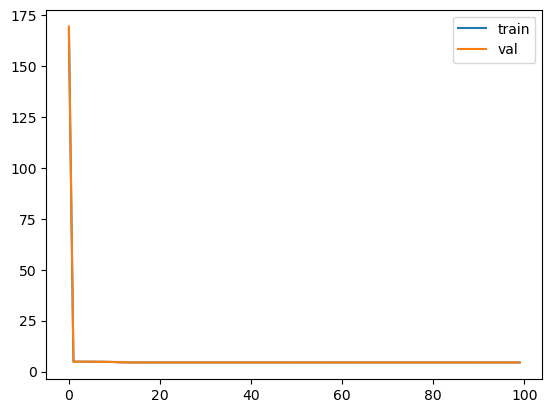

In [69]:
llama = Llama()
optimizer = torch.optim.Adam(llama.parameters())
train(llama, optimizer)

## Test and validation

In [82]:
@torch.no_grad()
def calculate_accuracy_test(model):
    model.eval()
    correct_predictions = 0
    total_predictions = 0
    
    for i in range(EPOCHS):
        x_test, y_test = get_batch_test(dataset_tensor, BATCH_SIZE, CONTEXT_WINDOW)
        
        logits = model(x_test)
        
        predicted_labels = torch.argmax(logits, dim=-1)
        
        correct_predictions += (predicted_labels == y_test).sum().item()
        total_predictions += y_test.numel()
    
    accuracy = correct_predictions / total_predictions
    return accuracy

In [96]:
@torch.no_grad()
def calculate_perplexity(model):
    model.eval()
    perp_sum = 0

    for i in range(EPOCHS):
        x_test, y_test = get_batch_test(dataset_tensor, BATCH_SIZE, CONTEXT_WINDOW)
        outputs = model(x_test)
        loss = F.cross_entropy(outputs.view(-1, outputs.size(-1)), y_test.view(-1), reduction='mean')
        perplexity = torch.exp(loss)
        perp_sum += perplexity.item()
    
    perplexity_final = perp_sum/EPOCHS
    return perplexity_final

In [97]:
def test(model):
    model.eval()  # Set the model to evaluation mode    
    with torch.no_grad():  # Disable gradient calculation        
        test_accuracy = calculate_accuracy_test(model)
        test_perplexity = calculate_perplexity(model)
        
    print(f"Test Accuracy: {test_accuracy}")
    print(f"Test Perplexity: {test_perplexity}")

    return {
        'accuracy': test_accuracy,
        'perplexity': test_perplexity
    }


In [98]:
llama_test = test(llama)

Test Accuracy: 0.056173828125
Test Perplexity: 87.69882926177978
